### data0 - all car images, including whole and damaged

In [60]:
import urllib.request
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import pickle as pk
from sklearn.metrics import classification_report, confusion_matrix


In [21]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

#from keras.utils.data_utils import get_file
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, History

In [3]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [20]:
# from Keras GitHub  
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = tf.keras.utils.get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [5]:
vgg16 = VGG16(weights='imagenet')

In [6]:
vgg16.save('vgg16.h5')

In [7]:
resnet50 = ResNet50(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
inception = InceptionV3(weights='imagenet')

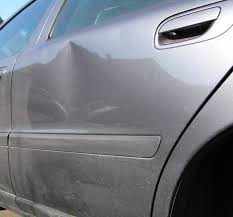

In [8]:
Image('test.jpeg', width=200)

In [9]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Testing with different models

In [15]:
y = prepare_image('test.jpeg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5)

40960/35363 [==================================] - 2s 43us/step
[[('n03770679', 'minivan', 0.29431078), ('n02917067', 'bullet_train', 0.29336697), ('n02974003', 'car_wheel', 0.101423405), ('n04285008', 'sports_car', 0.08902774), ('n03459775', 'grille', 0.06448862)]]


In [22]:
z = preprocess_input(x)
preds = resnet.predict(z)
print(get_predictions(preds))

NameError: name 'x' is not defined

In [77]:
a = preprocess_input(x)
preds = vgg19.predict(a)
print get_predictions(preds)

[[(u'n04493381', u'tub', 0.3188411), (u'n02808440', u'bathtub', 0.19447012), (u'n04447861', u'toilet_seat', 0.071480118), (u'n04049303', u'rain_barrel', 0.06163064), (u'n02951358', u'canoe', 0.050739273)]]


## Using VGG16 as Gate

In [67]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('car-damage-dataset/data0')
    for i, img_path in enumerate(img_list):
        img = prepare_image('car-damage-dataset/data0/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 50 == 0:
            print(i, '/', len(img_list), 'complete')
    return Counter(d)

In [68]:
cat_counter = get_car_categories()

0 / 1712 complete
50 / 1712 complete
100 / 1712 complete
150 / 1712 complete
200 / 1712 complete
250 / 1712 complete
300 / 1712 complete
350 / 1712 complete
400 / 1712 complete
450 / 1712 complete
500 / 1712 complete
550 / 1712 complete
600 / 1712 complete
650 / 1712 complete
700 / 1712 complete
750 / 1712 complete
800 / 1712 complete
850 / 1712 complete
900 / 1712 complete
950 / 1712 complete
1000 / 1712 complete
1050 / 1712 complete
1100 / 1712 complete
1150 / 1712 complete
1200 / 1712 complete
1250 / 1712 complete
1300 / 1712 complete
1350 / 1712 complete
1400 / 1712 complete
1450 / 1712 complete
1500 / 1712 complete
1550 / 1712 complete
1600 / 1712 complete
1650 / 1712 complete
1700 / 1712 complete


In [43]:
with open('cat_counter.pk', 'wb') as f:
    pk.dump(cat_counter,f,-1)

### Load Pickle Point

In [44]:
with open('cat_counter.pk', 'rb') as f:
    cat_counter = pk.load(f)

In [45]:
cat_list = [k for k, v in cat_counter.most_common()[:50]]

## Evaluating Car Categories from Imagenet

In [50]:
def get_car_categories(cat_list):
    img_list = os.listdir('car-damage-dataset/data0')
    num = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image('car-damage-dataset/data0/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            if j[0:2] in cat_list:
                num += 1
                break # breaks out of for loop if one of top 50 categories is found
            else:
                pass
            bad_list.append(img_path) # appends to "bad list" if none of the 50 are found
        if i % 100 == 0:
            print(i, '/', len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return num, bad_list

In [51]:
number, bad_list = get_car_categories(cat_list)

0 / 1712 complete
100 / 1712 complete
200 / 1712 complete
300 / 1712 complete
400 / 1712 complete
500 / 1712 complete
600 / 1712 complete
700 / 1712 complete
800 / 1712 complete
900 / 1712 complete
1000 / 1712 complete
1100 / 1712 complete
1200 / 1712 complete
1300 / 1712 complete
1400 / 1712 complete
1500 / 1712 complete
1600 / 1712 complete
1700 / 1712 complete


In [210]:
number2, bad_list2 = car_categories_gate(cat_list2)

0 / 1309 complete
100 / 1309 complete
200 / 1309 complete
300 / 1309 complete
400 / 1309 complete
500 / 1309 complete
600 / 1309 complete
700 / 1309 complete
800 / 1309 complete
900 / 1309 complete
1000 / 1309 complete
1100 / 1309 complete
1200 / 1309 complete
1300 / 1309 complete


In [212]:
number2, bad_list2 = car_categories_gate(cat_list2)

2

## Select top 50 as cutoff for category list

In [54]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

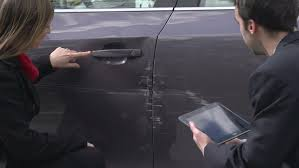

c to continue, q to quitc


In [56]:
view_images('car-damage-dataset/data0/', bad_list)

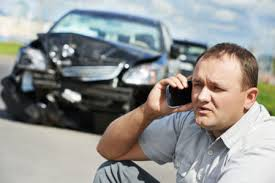

c to continue, q to quitc


In [213]:
view_images('data0/', bad_list2)

## Gate Implementation

In [61]:
def car_categories_gate(image_path, cat_list):
    urllib.request.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = prepare_image('save.jpg')
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print("Validating that this is a picture of your car...")
    for j in top[0]:
        if j[0:2] in cat_list:
            print(j[0:2])
            return "Validation complete - proceed to damage evaluation"
    return "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

In [64]:
car_categories_gate('https://t1.daumcdn.net/cfile/tistory/9984BF465EC7800906', cat_list)

Validating that this is a picture of your car...


'Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again.'

In [63]:
car_categories_gate('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7xHO3j12Xk4q4eaQUL1A02k1HrJ9G_RY6tj-4h-07EfdML6YL', cat_list)

Validating that this is a picture of your car...
('n02747177', 'ashcan')


'Validation complete - proceed to damage evaluation'

In [65]:
print(cat_list)

[('n03770679', 'minivan'), ('n04285008', 'sports_car'), ('n03100240', 'convertible'), ('n02814533', 'beach_wagon'), ('n03930630', 'pickup'), ('n03670208', 'limousine'), ('n04461696', 'tow_truck'), ('n04037443', 'racer'), ('n03594945', 'jeep'), ('n02974003', 'car_wheel'), ('n03459775', 'grille'), ('n03769881', 'minibus'), ('n04252225', 'snowplow'), ('n02930766', 'cab'), ('n03796401', 'moving_van'), ('n03977966', 'police_van'), ('n03445924', 'golfcart'), ('n03417042', 'garbage_truck'), ('n02701002', 'ambulance'), ('n03791053', 'motor_scooter'), ('n03478589', 'half_track'), ('n02704792', 'amphibian'), ('n04252077', 'snowmobile'), ('n04467665', 'trailer_truck'), ('n03777568', 'Model_T'), ('n04065272', 'recreational_vehicle'), ('n02917067', 'bullet_train'), ('n03345487', 'fire_engine'), ('n02965783', 'car_mirror'), ('n04465501', 'tractor'), ('n03127747', 'crash_helmet'), ('n03891332', 'parking_meter'), ('n02747177', 'ashcan'), ('n03649909', 'lawn_mower'), ('n03776460', 'mobile_home'), ('n02